In [1]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch

from models.simplepose import SimplePose
from models.datasets.lsp import LSPet, LSP

import numpy as np
from vis import show_pose

from torch.utils.tensorboard import SummaryWriter

In [2]:
# Load data
batch_size = 8

image_size = (128, 128)
# hmap_size = 32

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

lsp = LSPet('./dataset/lspet_dataset/', transform, image_size)
lsp_loader = DataLoader(lsp, batch_size, shuffle=True, num_workers=1)

In [3]:
class MSELoss(torch.nn.Module):
    
    def __init__(self):
        super(MSELoss, self).__init__()
        
    def forward(self, output, joints, mask):
        mask = torch.cat((mask.unsqueeze(2), mask.unsqueeze(2)), axis=2).reshape((-1, 28))
        return torch.sum(mask * (output - joints)**2)

In [4]:
# Initialize the model
model = SimplePose().cuda()

# model.load_state_dict(torch.load('./cpm_weights/cpm10+4+9+2.weights'))

criterion = MSELoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [5]:
# Add network into tensorboard
data = next(iter(lsp_loader))

tb = SummaryWriter()
tb.add_graph(model, data[0].cuda())
# tb.close()

In [6]:
# Train the model
for epoch in range(100):
    for batch, batch_data in enumerate(lsp_loader):

        model.zero_grad()

        input_image = batch_data[0].cuda()
        joints_hmap = batch_data[1].cuda()
        mask = batch_data[3].cuda()
        

        prediction = model(input_image)

        loss = criterion(prediction, joints_hmap, mask)
        loss.backward()
        optimizer.step()

        # Tensorboard
        tb.add_scalar('Loss', loss, 1250*epoch + batch)

        if batch % 100 == 0:
            print('Batch: {}, Loss: {}, Epoch: {}'.format(batch, loss, epoch))
            # Add keypoints loss of testing data
    
    # Tensorboard
    # for name, weight in model.named_parameters():
    #     tb.add_histogram(name, weight, epoch)
    #     tb.add_histogram(f'{name}.grad', weight.grad, epoch)        

    torch.cuda.empty_cache()
    torch.save(model.state_dict(), './cpm{}.weights'.format(epoch))

tb.close()

Batch: 0, Loss: 55.857215881347656, Epoch: 0
Batch: 100, Loss: 4.801026821136475, Epoch: 0
Batch: 200, Loss: 8.114561080932617, Epoch: 0
Batch: 300, Loss: 5.1961750984191895, Epoch: 0
Batch: 400, Loss: 4.6807074546813965, Epoch: 0
Batch: 500, Loss: 8.434078216552734, Epoch: 0


KeyboardInterrupt: 

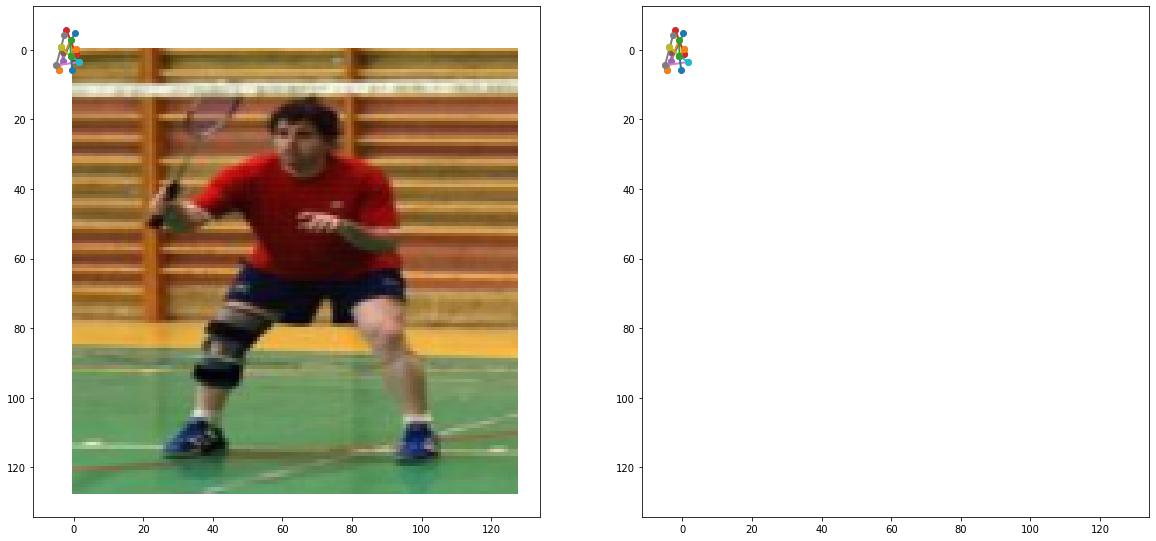

In [7]:
lsp_test = LSP('./dataset/lsp_dataset/', transform, image_size)
test_image, *_ = lsp_test.__getitem__(np.random.randint(len(lsp_test)))
test_predictions =  model(test_image.unsqueeze(0).cuda())
show_pose(test_image, test_predictions.squeeze().cpu().detach())